# Analyze STRF Parameters #
### Written by Kushal Bakshi and Ethan Vega for Dr. Mike Smotherman's Lab at Texas A&M University ###

## Objective: Quantify differences in parameters of different types of STRFs ##

> The notebook imports parameters of spectrotemporal receptive fields obtained from microelectrode array recordings from the primary auditory cortex (A1) of Mexican Free-Tailed Bats. Data indicates 4 categories of STRF are presented in the bat A1. The goal of this notebook is to quantify differences among single and multipeak STRFs before analyzing each of the 4 categories in more detail.  

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene, kruskal
import scikit_posthocs as sp
from statsmodels.multivariate.manova import MANOVA
import seaborn as sns
from scipy.io import loadmat

In [2]:
def load_strf_summary(strfFilepath, peakFilepath):
    summary = loadmat(strfFilepath, squeeze_me = True)
    paramDF = pd.DataFrame(summary['strf_table'], columns = summary['strf_table'][0])
    paramDF = paramDF.drop(index = 0).reset_index()
    paramDF.drop(labels = 'index', axis = 1, inplace = True)
    paramDF['Peaks'] = pd.read_excel(peakFilepath, header=0, sheet_name='Spike Sorting', usecols='E')
    paramDF['Type'] = pd.read_excel(peakFilepath, header=0, sheet_name='Spike Sorting', usecols='F')
    return paramDF

In [3]:
def plotResiduals(fitted_values, residuals):
    fig, ax1 = plt.subplots(figsize=(10, 7))
    sns.regplot(fitted_values, residuals, ax=ax1)
    ax1.set_title('Residuals Plot')
    ax1.set_xlabel('Fitted Values')
    ax1.set_ylabel('Residuals')
    plt.show()

In [4]:
#logit_mod Function

def logit(predictors, modelDF):
    logit_mod = sm.Logit(modelDF['Peaks'].astype(int), modelDF[predictors]).fit()
    print('logit_mod AIC = ', logit_mod.aic)
    print(logit_mod.summary())
    return logit_mod

In [5]:
strf_summary = load_strf_summary(strfFilepath='C:/Users/kbakshi/Documents/Data/STRF Analysis/sorted_STRFs_032522.mat', peakFilepath='C:/Users/kbakshi/Documents/Data/STRF Analysis/STRF Summary.xlsx')
strf_summary['Peaks']= strf_summary['Peaks'].apply(lambda x: '0' if (x > 1) else '1')
col_list = list(strf_summary.columns)
for column in range(2, len(col_list)-2):
    strf_summary[col_list[column]] = strf_summary[col_list[column]].astype('float64')

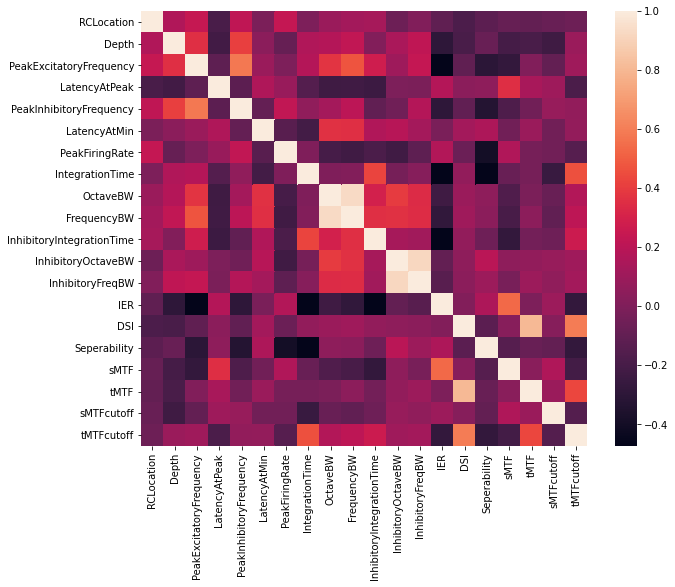

In [6]:
# Find correlations among predictors
plt.figure(figsize=(10,8))
sns.heatmap(strf_summary.corr())
plt.show()

In [7]:
# Drop one of the highly correlated variables
strf_summary.drop(columns={'InhibitoryOctaveBW', 'OctaveBW'}, inplace=True)
col_list = list(strf_summary.columns)

In [8]:
# Check for NaN values
strf_summary.columns[strf_summary.isna().any()].tolist()

['PeakInhibitoryFrequency',
 'LatencyAtMin',
 'InhibitoryIntegrationTime',
 'InhibitoryFreqBW']

In [9]:
strf_summary.fillna(0, inplace=True)
for column in range(4, len(col_list)-2):
    print(col_list[column] + ':')
    print(shapiro(strf_summary[col_list[column]]))
    print('')

PeakExcitatoryFrequency:
ShapiroResult(statistic=0.9295251369476318, pvalue=3.801259026658954e-06)

LatencyAtPeak:
ShapiroResult(statistic=0.946010410785675, pvalue=5.303092621034011e-05)

PeakInhibitoryFrequency:
ShapiroResult(statistic=0.9660107493400574, pvalue=0.0022935662418603897)

LatencyAtMin:
ShapiroResult(statistic=0.6977862119674683, pvalue=4.4817961665564836e-15)

PeakFiringRate:
ShapiroResult(statistic=0.8911060094833374, pvalue=2.441733570890392e-08)

IntegrationTime:
ShapiroResult(statistic=0.9937103390693665, pvalue=0.8322111368179321)

FrequencyBW:
ShapiroResult(statistic=0.7386935353279114, pvalue=5.605868688089016e-14)

InhibitoryIntegrationTime:
ShapiroResult(statistic=0.7059593200683594, pvalue=7.274185119814265e-15)

InhibitoryFreqBW:
ShapiroResult(statistic=0.7810826301574707, pvalue=1.0523318327848585e-12)

IER:
ShapiroResult(statistic=0.9444811940193176, pvalue=4.0883838664740324e-05)

DSI:
ShapiroResult(statistic=0.9664171934127808, pvalue=0.002495575696229934

In [10]:
# Split by single/multi peak STRF
multi_peak = strf_summary[strf_summary['Peaks'] == '0']
one_peak = strf_summary[strf_summary['Peaks'] == '1']

In [15]:
# Test for heteroscedasticity. Levene's test in cases where samples are highly non-normal

for column in range(4, len(col_list)-2):
    _, p = levene(one_peak[col_list[column]], multi_peak[col_list[column]], center='median')
    print(col_list[column] + ': ' + str(p))

PeakExcitatoryFrequency: 0.6881074214003853
LatencyAtPeak: 0.022513823607154232
PeakInhibitoryFrequency: 0.29319065793470184
LatencyAtMin: 0.4439861819801979
PeakFiringRate: 0.3803214456887949
IntegrationTime: 0.7504575013842332
FrequencyBW: 0.4881892577699479
InhibitoryIntegrationTime: 0.5319244260354721
InhibitoryFreqBW: 0.8297960948048588
IER: 0.7270721095903818
DSI: 0.628971963202942
Seperability: 0.866287663681288
sMTF: 0.6683309702628515
tMTF: 0.14181463319683255
sMTFcutoff: 0.24358009511666542
tMTFcutoff: 0.2997252745472267


Above results indicate dissimilar (non-equal) variances

In [22]:
col_list

['Bat',
 'ExperimentalSite',
 'RCLocation',
 'Depth',
 'PeakExcitatoryFrequency',
 'LatencyAtPeak',
 'PeakInhibitoryFrequency',
 'LatencyAtMin',
 'PeakFiringRate',
 'IntegrationTime',
 'FrequencyBW',
 'InhibitoryIntegrationTime',
 'InhibitoryFreqBW',
 'IER',
 'DSI',
 'Seperability',
 'sMTF',
 'tMTF',
 'sMTFcutoff',
 'tMTFcutoff',
 'Peaks',
 'Type']

In [27]:
fit = MANOVA.from_formula('RCLocation + Depth + PeakExcitatoryFrequency + LatencyAtPeak + PeakInhibitoryFrequency + LatencyAtMin + PeakFiringRate + IntegrationTime +' +
                          'DSI + tMTFcutoff + sMTFcutoff + FrequencyBW + InhibitoryIntegrationTime + InhibitoryFreqBW + IER + Seperability + sMTF + tMTF ~ Peaks', data=strf_summary)

In [28]:
print(fit.mv_test())

                    Multivariate linear model
                                                                  
------------------------------------------------------------------
       Intercept         Value    Num DF  Den DF   F Value  Pr > F
------------------------------------------------------------------
          Wilks' lambda   0.0060 18.0000 112.0000 1029.9210 0.0000
         Pillai's trace   0.9940 18.0000 112.0000 1029.9210 0.0000
 Hotelling-Lawley trace 165.5230 18.0000 112.0000 1029.9210 0.0000
    Roy's greatest root 165.5230 18.0000 112.0000 1029.9210 0.0000
------------------------------------------------------------------
                                                                  
------------------------------------------------------------------
             Peaks          Value   Num DF  Den DF  F Value Pr > F
------------------------------------------------------------------
              Wilks' lambda 0.7449 18.0000 112.0000  2.1314 0.0088
             Pil

In [30]:
model_1 = logit(predictors=col_list[2:-2], modelDF=strf_summary)

Optimization terminated successfully.
         Current function value: 0.561802
         Iterations 6
logit_mod AIC =  183.19212726200095
                           Logit Regression Results                           
Dep. Variable:                  Peaks   No. Observations:                  131
Model:                          Logit   Df Residuals:                      113
Method:                           MLE   Df Model:                           17
Date:                Tue, 29 Mar 2022   Pseudo R-squ.:                  0.1867
Time:                        14:08:06   Log-Likelihood:                -73.596
converged:                       True   LL-Null:                       -90.493
Covariance Type:            nonrobust   LLR p-value:                  0.008926
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
RCLocation                   -0.0008      

In [34]:
model_2 = logit(predictors = ['DSI', 'Seperability', 'sMTFcutoff', 'Depth', 'LatencyAtMin', 'FrequencyBW'], modelDF=strf_summary)

Optimization terminated successfully.
         Current function value: 0.583649
         Iterations 5
logit_mod AIC =  164.91608106282052
                           Logit Regression Results                           
Dep. Variable:                  Peaks   No. Observations:                  131
Model:                          Logit   Df Residuals:                      125
Method:                           MLE   Df Model:                            5
Date:                Tue, 29 Mar 2022   Pseudo R-squ.:                  0.1551
Time:                        14:20:59   Log-Likelihood:                -76.458
converged:                       True   LL-Null:                       -90.493
Covariance Type:            nonrobust   LLR p-value:                 3.527e-05
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
DSI             -1.3827      0.494     -2.799      0.005      -2.351

C:\Users\kbakshi\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


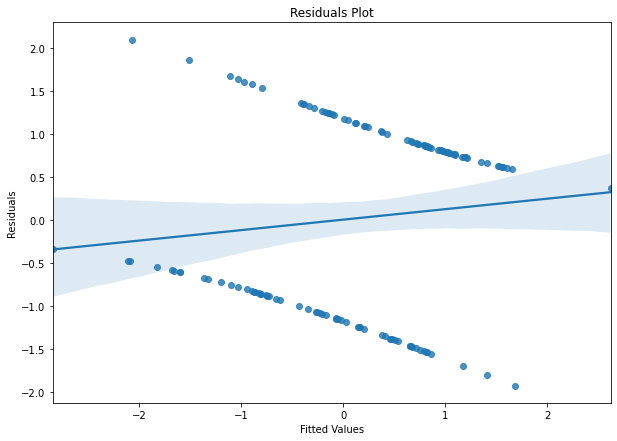

In [33]:
plotResiduals(model_2.fittedvalues, model_2.resid_dev)

In [ ]:
#2 Sample T-Test (for now?) for Seperability and Average Direction Selectivity

seperability_1 = strf_summary.loc[(strf_summary['Peaks'] == 1)]
seperability_2 = strf_summary.loc[(strf_summary['Peaks'] == 2)]

#stats.ttest_ind(a=seperability_1, b=seperability_2, equal_var=True)

In [ ]:
#Models

#One Peak
strf_one = strf_summary[strf_summary['Peaks'] == 1]
emo = strf_one['PeakExcitatoryFrequency'].mean()
imo = strf_one['PeakInhibitoryFrequency'].mean()
print(emo, imo)

#Two Peak
strf_two = strf_summary[strf_summary['Peaks'] == 2]
emt = strf_two['PeakExcitatoryFrequency'].mean()
imt = strf_two['PeakInhibitoryFrequency'].mean()
print(emt, imt)

#Bar Graph for PEF and PIM

X = ['Peak Excitatory Frequency','Peak Inhibitory Frequency']
onepeak = [43.8147490175195, 38.2506299015672]
twopeak = [48.11933407373453, 44.98541848424552]
  
X_axis = np.arange(len(X))
Y_axis = 70
  
plt.bar(X_axis - 0.1, onepeak, 0.2, label = '1 Peak', color = 'green')
plt.bar(X_axis + 0.1, twopeak, 0.2, label = '2 Peaks', color = 'navy')

plt.xticks(X_axis, X)
plt.xlabel("...")
plt.ylabel("Frequency (kHz)")
plt.title("...")
plt.legend()
plt.show()

In [ ]:
#Bar Graph for SMTF

emo = strf_one['sMTF'].mean()
imo = strf_one['tMTF'].mean()
print(emo, imo)

strf_two = strf_summary[strf_summary['Peaks'] == 2]
emt = strf_two['sMTF'].mean()
imt = strf_two['tMTF'].mean()
print(emt, imt)